# Cycle benchmarking

- With parallel CNOT

- Apply 9 different measurement settings



In [1]:
import numpy as np
import sys, json, copy, time, pickle, random
from concurrent.futures import ThreadPoolExecutor
import qiskit
#transpiler reducinig qiskit circuit to QASM strings
from qiskit import transpile
# Use AerSimulator
from qiskit_aer import AerSimulator
from qiskit import IBMQ, QuantumCircuit, execute
# from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info import Pauli, Clifford, Statevector,Operator
from qiskit.visualization import array_to_latex
from scipy.stats import sem, unitary_group
from scipy.linalg import sqrtm,expm
import qiskit.quantum_info as qi
from qiskit.quantum_info import Pauli
from qiskit_aer.noise import NoiseModel, pauli_error, amplitude_damping_error, ReadoutError

# from qubit_map import my_qubit_maps
import matplotlib.pyplot as plt
from scipy.stats import sem, unitary_group
from scipy import sparse
from statistics import stdev
import itertools
from qiskit.compiler import transpile

from qiskit.quantum_info import Pauli
import sys
sys.path.append(r"/Users/yzhu/yzhu_work/gates projects/EAB/EAB_code from Senrui")
import CB_submit, CB_process


/var/folders/6l/f5pw0tyx785dhvmqpb7282h00000gn/T/ipykernel_1144/2818353290.py:11: DeprecationWarning: The qiskit.extensions module is deprecated since Qiskit 0.46.0. It will be removed in the Qiskit 1.0 release.
  from qiskit.extensions import UnitaryGate


In [2]:
#define qubit properties
# qiskit.providers.QubitProperties(t1=None, t2=0.6, frequency=None)

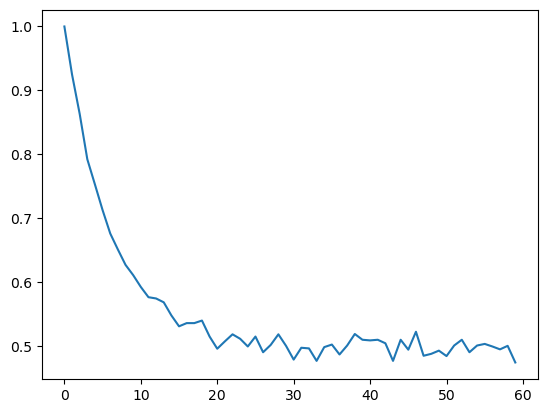

In [39]:
#simulate a Ramsey experiment with the defined t1 time to check if the error model is actually applied

import math
from math import pi
from qiskit.quantum_info import Statevector
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

#basic t2 error model
# T1 and T2 values for qubit
T1 = 1000000000000
T2 = 600000000

backend = AerSimulator()

# still not sure how to use this
# qiskit.providers.QubitProperties(t1=None, t2=0.6, frequency=None)

N=1
totalscansteps=60

pbright_l=[]
for i in range (totalscansteps):
    circ = QuantumCircuit(N)
    time_delay=0.1*i*1000000000 #in ns

    noise_model = NoiseModel()
    errors_delay = thermal_relaxation_error(T1, T2, time_delay)
    noise_model.add_quantum_error(errors_delay, "delay",[0])

    circ.rx(pi/2,0)
    circ.delay(time_delay,unit="ns")
    # circ.rz(2*pi/totalscansteps*i,0)
    circ.rx(pi/2,0)
    # circ.draw('mpl')
    # Set the initial state of the simulator to the ground state using from_int
    # state = Statevector.from_int(0, 2**N)
    # Evolve the state by the quantum circuit
    # state = state.evolve(circ)
    # state.draw('latex')
    # statef=state.data
   
    meas = QuantumCircuit(N, N)
    meas.barrier(range(N))
    # map the quantum measurement to the classical bits
    meas.measure(range(N), range(N))

    # The Qiskit circuit object supports composition.
    # Here the meas has to be first and front=True (putting it before) as compose must put a smaller circuit into a larger one.
    qc = meas.compose(circ, range(N), front=True)
    qc_compiled = transpile(qc, backend)
    job_sim = backend.run(qc_compiled, shots=2000,noise_model=noise_model)
    result_sim = job_sim.result()
    counts = result_sim.get_counts(qc_compiled)
    #drawing the circuit
    # qc.draw('mpl')
    p_bright=counts["1"]/2000
    # print (p_bright)
    pbright_l.append(p_bright)

plt.plot(pbright_l)


## Additional functions

In [5]:
## Additional functions

def int_to_pauli(i,n):
    p = np.base_repr(i,base=4)
    p = '0'*(n-len(p)) + p
    p = p.replace('0','I').replace('1', 'X').replace('2', 'Y').replace('3', 'Z')
    return p

def commute(p,q):
    c = 1
    n = len(p)
    for i in range(n):
        if p[i] != 'I' and q[i] != 'I':
            if p[i] != q[i]:
                c *= -1
    return c

def fidelity_to_error(pauli_fidelity,n):
    N = 4**n
    pauli_error = {}
    for i in range(N):
        p = int_to_pauli(i,n)
        pauli_error[p] = 0
        for j in range(N):
            q = int_to_pauli(j,n)
            pauli_error[p] += pauli_fidelity[q] * commute(p,q) / N
    return pauli_error
    

## Data generation

In [ ]:

use_density_matrix = False # density matrix based / measurement based simulation

# choose one
use_ibmq = False
use_stabilizer_simulator = True # whether stabilizer simulator is used (valid only for Pauli noise)
use_density_matrix_sample = False # use density matrix simulation, but returns samples
use_state_vector_sample = False # use state vector simulation, which returns samples

# parameters: n, Lrange, C, shots
use_readout_error = True
shots = 2000
n = 2 # num of qubit
n_total = n
# Lrange = list(range(2,39,4)) # len = 10
Lrange = [2**x for x in range(1,6)]
C = 5
batch = 1 # not used
gset = "Pauli"
q = my_qubit_maps['local']
repeat = [1 for k in Lrange] # not used
periodic = False # not used

# For CB, need to decide measurement basis
pauli_sample_list = [''.join(s) for s in itertools.product(['X','Y','Z'], repeat = n)]
# pauli_sample_list = ['XZ','ZX']


# For specific IBM device structure
# TODO: put these in qubit_map.py
# q = {
#     0:0,
#     2:1,
#     1:3,
#     3:4,
#     4:2
# }
# q = {
#     0:0,
#     2:1,
#     1:2,
#     3:3,
#     4:4
# }

clifford_layer = 'CNOT'
# clifford_layer = 'Id'

# Simulation parameters
eps = 0.005 # two parallel Cnot ~ 2%
# eps_amp = 0.025 # SPAM error at CNOT
eps_readout = 0.01 # readout bitflip ~ 1%
# eps_cross = 0.025 # SPAM error at CNOT

noise_model = NoiseModel()
# # noise_model.add_all_qubit_quantum_error(pauli_error([('I',1-eps),('X',eps)]),['id', 'x', 'y','z'])
# noise_model.add_all_qubit_quantum_error(pauli_error([('II',(1-eps)**2),('XX',eps**2),('IX',eps*(1-eps)),('XI',eps*(1-eps))]),['cx'])
T1 = 1000000000000
T2 = 600000000


# # phase/amplitude damping error
# amp_noise_1q = amplitude_damping_error(eps_amp)
# noise_model.add_all_qubit_quantum_error(amp_noise_1q.tensor(amp_noise_1q),['cx'])

# # crosstalk between CNOTs (choose it to be ZZ)
# crosstalk_noise = pauli_error([('II',1-eps_cross),('ZZ',eps_cross)])
# for i in range(n-2):
#     noise_model.add_nonlocal_quantum_error(crosstalk_noise, ['cx'], [i,i+1], [i+1,i+2])
# noise_model.add_nonlocal_quantum_error(crosstalk_noise, ['cx'], [n-2,n-1], [n-1,0])
# noise_model.add_nonlocal_quantum_error(crosstalk_noise, ['cx'], [n-1,0], [0,1])

# readout error
if use_readout_error is True:
    p0given1 = eps_readout
    p1given0 = eps_readout
    readout_noise_1q = ReadoutError([[1 - p1given0, p1given0], [p0given1, 1 - p0given1]])
    noise_model.add_all_qubit_readout_error(readout_noise_1q)



if use_ibmq is False:
    filename = 'sim_cb_cnot_2022oct'
else:
    filename = 'exp_cb_cnot_2022oct'
    job_manager = IBMQJobManager()



if use_density_matrix or use_density_matrix_sample:
    backend = AerSimulator(method='density_matrix', noise_model=noise_model)
elif use_state_vector_sample:
    backend = AerSimulator(method='statevector', noise_model=noise_model)
elif use_stabilizer_simulator:
    backend = AerSimulator(method='stabilizer', noise_model=noise_model)
elif use_ibmq:
    provider = IBMQ.load_account()
    backend = provider.get_backend('ibmq_manila')
else:
    assert 1==0

print("CB, ", "n=%d" % n)
print("simulation method:", backend.configuration().description)
if use_density_matrix:
    print("Density matrix based simulation")
else:
    print("Measurement based simulation, shots = %d" % shots)

if use_readout_error is True:
    print("Measurement bitflip rate = %f" % eps_readout)
else:
    print("No readout error")


data = {}
token = ''.join(random.choice([str(j) for j in range(10)]) for i in range(10))
filename += '_' + token
data["token"] = token
data["n"] = n
data["pauli_sample_list"] = pauli_sample_list



for pauli_sample in pauli_sample_list:
    print("CB for ",pauli_sample)
    # generate CB circuit:
    cb_data, cb_circ_all = CB_submit.submit_cb(n,n_total,clifford_layer = clifford_layer,Lrange=Lrange,C=C,batch=batch, qubit_map=q, pauliList=pauli_sample , gset=gset,repeat=repeat,periodic=periodic,use_density_matrix=use_density_matrix)
    print("created %d circuits" % len(cb_circ_all[0]))

    print(cb_circ_all[0][0]) # print a typical example

    # print(transpile(cb_circ_all[0][0],basis_gates=backend.configuration().basis_gates))
    # print(transpile(cb_circ_all[0][0],optimization_level=3,basis_gates=backend.configuration().basis_gates,coupling_map=backend.configuration().coupling_map,initial_layout=q))

    # sys.exit(0)

    if use_density_matrix is True:
        job = backend.run(cb_circ_all[0], shots=1, max_parallel_experiments=0) 
    elif use_ibmq is False:
        job = backend.run(cb_circ_all[0], shots=shots, max_parallel_experiments=0, memory = True) 
    else:
        job = backend.run(transpile(cb_circ_all[0],basis_gates=backend.configuration().basis_gates), shots=shots, memory = True) 
    result = job.result()
    cb_data["result"] = [result]

    cb_data["parameters"] = {}
    cb_data["parameters"]['n'] = n 
    cb_data["parameters"]['n_total'] = n_total
    cb_data["parameters"]['shots'] = shots 
    cb_data["parameters"]['Lrange'] = Lrange 
    cb_data["parameters"]['C'] = C
    cb_data["parameters"]['eps_readout'] = eps_readout
    cb_data["parameters"]['repeat'] = repeat

    data[pauli_sample] = cb_data

# if use_ibmq is False:
#     cb_data["result"] = [result]
# else:
#     cb_data["job_set_id"] = job_set_id

# test: data saving
# print(cb_data)


with open('data/' + filename, 'wb') as outfile:
    pickle.dump(data, outfile)

print(token)

CB,  n=2
simulation method: A C++ Clifford stabilizer simulator with noise
Measurement based simulation, shots = 2000
Measurement bitflip rate = 0.010000
CB for  XX
created 25 circuits
     ┌───┐ ░ ┌───┐      ░ ┌───┐      ░ ┌───┐ ░ ┌───┐ ░ ┌─┐   
q_0: ┤ H ├─░─┤ Z ├──■───░─┤ X ├──■───░─┤ I ├─░─┤ H ├─░─┤M├───
     ├───┤ ░ ├───┤┌─┴─┐ ░ ├───┤┌─┴─┐ ░ ├───┤ ░ ├───┤ ░ └╥┘┌─┐
q_1: ┤ H ├─░─┤ Z ├┤ X ├─░─┤ X ├┤ X ├─░─┤ Z ├─░─┤ H ├─░──╫─┤M├
     └───┘ ░ └───┘└───┘ ░ └───┘└───┘ ░ └───┘ ░ └───┘ ░  ║ └╥┘
c: 2/═══════════════════════════════════════════════════╩══╩═
                                                        0  1 
CB for  XY
created 25 circuits
     ┌───┐┌───┐ ░ ┌───┐      ░ ┌───┐      ░ ┌───┐ ░ ┌───┐┌───┐┌───┐┌───┐ ░ ┌─┐»
q_0: ┤ H ├┤ S ├─░─┤ X ├──■───░─┤ Z ├──■───░─┤ Z ├─░─┤ S ├┤ S ├┤ S ├┤ H ├─░─┤M├»
     ├───┤└───┘ ░ ├───┤┌─┴─┐ ░ ├───┤┌─┴─┐ ░ ├───┤ ░ ├───┤└───┘└───┘└───┘ ░ └╥┘»
q_1: ┤ H ├──────░─┤ Z ├┤ X ├─░─┤ Z ├┤ X ├─░─┤ I ├─░─┤ H ├────────────────░──╫─»
     └───┘      ░ └───┘└───┘ ░

In [ ]:
for i in range(len(data["XX"]["batch_0"])):
    print (data["XX"]["batch_0"][i]["pauli"])

-XX
-XX
XX
XX
XX
-XX
XX
XX
XX
-XX
-XX
-XX
-XX
XX
XX
XX
XX
-XX
-XX
-XX
XX
-XX
-XX
XX
XX


## Data analysis

In [ ]:
print (data.keys())
# print (data["pauli_sample_list"])
print (data["XX"].keys())
print (type(data["XX"]["result"]))
print (data["XX"]["result"][0].data(0)["memory"])
print (data["XX"]["result"][0].data(0)["counts"])

dict_keys(['token', 'n', 'pauli_sample_list', 'XX', 'XY', 'XZ', 'YX', 'YY', 'YZ', 'ZX', 'ZY', 'ZZ'])
dict_keys(['batch_0', 'result', 'parameters'])
<class 'list'>
['0x2', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x3', '0x

In [ ]:


'''Use these if read from file'''
# token = "8799418287"
filename = "sim_cb_cnot_2022oct_" + token
with open('/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/EAB(code from Senrui)/data/' + filename, 'rb') as infile:
    data = pickle.load(infile)


n = data["n"]
pauli_sample_list = data["pauli_sample_list"]
'''Specify a set of Pauli you want to estimate'''
pauli_request_list = [''.join(s) for s in itertools.product(['I','X','Y','Z'], repeat = n)] #full

fidelity_list = {} 
stdev_list = {}

for pauli_sample in pauli_sample_list:
    cb_data = data[pauli_sample]

    # n = cb_data["parameters"]['n']
    # n_total = cb_data["parameters"]['n_total'] 
    shots = cb_data["parameters"]['shots'] 
    Lrange = cb_data["parameters"]['Lrange']
    C = cb_data["parameters"]['C'] 
    eps_readout = cb_data["parameters"]['eps_readout'] 
    repeat = cb_data["parameters"]['repeat']

    cb_result = CB_process.process_CB(n, C, shots, 1, Lrange, cb_data, pauli_sample = pauli_sample,repeat=repeat, periodic=True,use_density_matrix=False, intercept_cb=False)
    raw_fidelity_list = cb_result["fidelity_list"]
    
    new_sub_label = []

    for sub_label in raw_fidelity_list.keys():
        if sub_label in fidelity_list:
            continue # wasteful!
        elif(sub_label == 'I'*n):
            fidelity_list[sub_label] = 1.0
            stdev_list[sub_label] = 0.0
        else:
            alpha, alpha_err = CB_process.fit_CB(Lrange, raw_fidelity_list[sub_label])
            fidelity_list[sub_label] = alpha
            stdev_list[sub_label] = alpha_err
            new_sub_label.append(sub_label)

    print("CB setting: ",pauli_sample[::-1]," Pauli fidelities calculated: ", [sub_label[::-1] for sub_label in new_sub_label])


# print(fidelity_list)

# print(stdev_list)
print("Parameters: n = %d, C = %d, " % (n,C), "L = ", str(Lrange))



# Average fidelity
print("Total error = ", 1-np.mean(list(fidelity_list.values())))

print("Label / Pauli infidelity / Standard deviation")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], 1-fidelity_list[pauli_label], stdev_list[pauli_label])
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))



CB setting:  XX  Pauli fidelities calculated:  ['XI', 'IX', 'XX']
CB setting:  YX  Pauli fidelities calculated:  ['YI', 'YX']
CB setting:  ZX  Pauli fidelities calculated:  ['ZI', 'ZX']
CB setting:  XY  Pauli fidelities calculated:  ['IY', 'XY']
CB setting:  YY  Pauli fidelities calculated:  ['YY']
CB setting:  ZY  Pauli fidelities calculated:  ['ZY']
CB setting:  XZ  Pauli fidelities calculated:  ['IZ', 'XZ']
CB setting:  YZ  Pauli fidelities calculated:  ['YZ']
CB setting:  ZZ  Pauli fidelities calculated:  ['ZZ']
Parameters: n = 2, C = 5,  L =  [2, 4, 8, 16, 32]
Total error =  0.009977087917791172
Label / Pauli infidelity / Standard deviation
II 0.0 0.0
XI -9.578677677790637e-05 0.00011979438126552467
YI 0.010733575541696738 0.00032042718578585477
ZI 0.009447881468111596 0.0001971622261878265
IX 0.00010572351714033257 8.819608759008774e-05
XX 0.00012111049888630099 9.054985741562199e-05
YX 0.010773264285278139 0.00032748565410306145
ZX 0.00955177709959365 0.00023452182836657112
IY 0

In [ ]:
print (raw_fidelity_list)

{'II': {2: [1.0, 1.0, 1.0, 1.0, 1.0], 4: [1.0, 1.0, 1.0, 1.0, 1.0], 8: [1.0, 1.0, 1.0, 1.0, 1.0], 16: [1.0, 1.0, 1.0, 1.0, 1.0], 32: [1.0, 1.0, 1.0, 1.0, 1.0]}, 'IZ': {2: [0.959, 0.966, 0.967, 0.96, 0.968], 4: [0.93, 0.951, 0.938, 0.946, 0.927], 8: [0.909, 0.894, 0.903, 0.882, 0.905], 16: [0.82, 0.847, 0.83, 0.83, 0.823], 32: [0.702, 0.746, 0.749, 0.701, 0.704]}, 'ZI': {2: [0.946, 0.962, 0.958, 0.951, 0.949], 4: [0.905, 0.929, 0.918, 0.921, 0.921], 8: [0.858, 0.877, 0.87, 0.844, 0.879], 16: [0.766, 0.781, 0.762, 0.791, 0.765], 32: [0.586, 0.62, 0.578, 0.608, 0.59]}, 'ZZ': {2: [0.925, 0.946, 0.931, 0.941, 0.933], 4: [0.881, 0.914, 0.888, 0.913, 0.89], 8: [0.855, 0.839, 0.847, 0.816, 0.852], 16: [0.76, 0.762, 0.754, 0.757, 0.758], 32: [0.592, 0.592, 0.565, 0.593, 0.59]}}


Note that, the estimation suffers from some degeneracy. E.g., $\lambda_{IZ}$ and $\lambda_{ZZ}$ cannot be individually addressed. Only their geometric mean is estimated and reported. This issue is detailed in [The learnability of Pauli noise](https://arxiv.org/abs/2206.06362).

In [ ]:
error_list = fidelity_to_error(fidelity_list,n)
print("Label / Pauli error rates")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], error_list[pauli_label])

Label / Pauli error rates
II 0.9898758887924455
XI 0.0026089526073698535
YI -4.737289773781156e-05
ZI -1.9980359342100518e-06
IX 0.004832854037654578
XX 0.0026724426682888935
YX 1.6678637862387047e-05
ZX -1.0088696756692384e-05
IY 3.719169404359235e-05
XY -7.249404184481167e-05
YY 2.8763378182534993e-05
ZY -1.5993681546040694e-05
IZ -1.582459586230156e-05
XZ 9.541229674833729e-05
YZ -2.0102917254384567e-05
ZZ 1.5690754340692836e-05


Similarly, in the estimation $p_{XI}=p_{XX}=0.0025$ due to degeneracy.

In [ ]:
# True value for this specific noise model
eps = 0.005
def f_true(P):
    ans = 0.0
    for Pi in P:
        if Pi == 'Z' or Pi == 'Y':
            ans += 2*eps
    return ans
def p_true(P):
    if P == "XI" or P == "IX":
        return eps
    else:
        return 0.0

print("Label / True infidelity/ True Pauli error")
for P in pauli_request_list:
    print(P[::-1]," ",f_true(P)," ",p_true(P))

Label / True infidelity/ True Pauli error
II   0.0   0.0
XI   0.0   0.005
YI   0.01   0.0
ZI   0.01   0.0
IX   0.0   0.005
XX   0.0   0.0
YX   0.01   0.0
ZX   0.01   0.0
IY   0.01   0.0
XY   0.01   0.0
YY   0.02   0.0
ZY   0.02   0.0
IZ   0.01   0.0
XZ   0.01   0.0
YZ   0.02   0.0
ZZ   0.02   0.0


In [ ]:
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], (1-fidelity_list[pauli_label])-f_true(pauli_label))

II 0.0
XI -3.72240458179629e-05
YI 0.00011366131535684755
ZI 0.0003760411715055898
IX -8.145387763369705e-05
XX -0.00011494943944923008
YX 0.00016384049609397856
ZX 0.000473700769892069
IY 0.005677388220001753
XY 0.005370589308984939
YY -0.004615039021756844
ZY -0.0048058294033530395
IZ 0.004476540925792536
XZ 0.004580069852476396
YZ -0.0047195157624963895
ZZ -0.005029984350663801


In [ ]:
print (range(5))

range(0, 5)
